In [1]:
import mido # easy to use python MIDI library
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import random
import pandas as pd
import random
import math

from mido import MidiFile, MidiTrack, Message

import pickle

from sklearn import model_selection

In [2]:
def track_to_data(track):
    l = []
    for msg in track:
        if msg.type == 'note_on':
            note = msg.note
            velocity = msg.velocity
            time = msg.time
            l.append([note, velocity, time])
    return(l)

In [3]:
def midi_to_data(midi, track_name = 'right', return_track = False):
    a = 0
    for track in mid_file.tracks:
        if track.name == f'Piano {track_name}' or track.name == f'Piaro {track_name}' or track.name == track_name.capitalize():
            my_track = track
            a = 1
    if a == 0:
        print(f'Piano {track} not found')
        print(mid_file.tracks)
        return []
    my_track, data = transform_track(my_track)
    
    if return_track:
        return data, my_track 
        
    return data

In [4]:
def data_to_track(data):
    track = MidiTrack()
    for values in data:
        note = values[0]
        velocity = values[1]
        time = values[2]
        track.append(Message('note_on', channel=0, note=note, velocity=velocity, time=time))
    return(track)
    

In [5]:
def transform_track(track):
    data_1 = []
    time = 0
    for msg_id in range(len(track)):
        msg = track[msg_id]
        time += msg.time
        if msg.type == 'note_on':
            if msg.velocity > 0:
                msg_note = msg.note
                dur = 0
                for i in range(msg_id+1, len(track)):
                    dur += track[i].time
                    if track[i].type == 'note_on':
                        if track[i].velocity == 0 and track[i].note == msg_note:
                            break
                l = [msg.note, msg.velocity, dur, time]
                data_1.append(l)
    
    track_new = MidiTrack()
    time_init = 0
    
    data_2 = []
    for l in data_1:
        note = l[0]
        velocity = l[1]
        time = l[3] - time_init
        time_init = l[3]
        l = [note, velocity, l[2], time, l[3], l[3] + l[2]]
        data_2.append(l)

        track_new.append(Message('note_on', channel=0, note=note, velocity=velocity, time=time))
    
    return track_new, data_2

In [6]:
def save_track(tracks, path):
    mid = MidiFile()
    for track in tracks:
        mid.tracks.append(track)
    mid.save(path)

# Tests

In [8]:
path_midi = 'C:/Users/maxim/Desktop/DL_project/piano_dataset/Albéniz/alb_esp1.mid'
mid_file = MidiFile(path_midi, clip=True)
mid_file

<midi file 'C:/Users/maxim/Desktop/DL_project/piano_dataset/Albéniz/alb_esp1.mid' type 1, 8 tracks, 2027 messages>

In [ ]:
data_r = midi_to_data(mid_file, 'right')
data_r

In [ ]:
data_l = midi_to_data(mid_file, 'left')
data_l

# Generate sequences

In [9]:
def sort_seq(seq):
    L = [l[4] for l in seq]
    L2 = [(k,i) for i,k in enumerate(L)]
    L2.sort()
    sorted_indices = [l[1] for l in L2]
    return [seq[i] for i in sorted_indices]

In [10]:
def sort_and_compute_relative_time(seq, seq_start_time):
    
    if len(seq) > 0:
        
        sorted_seq = sort_seq(seq)
        sorted_seq[0][3] = sorted_seq[0][4] - seq_start_time
        
        for i in range(1,len(seq)):
            sorted_seq[i][3] = sorted_seq[i][4] - sorted_seq[i-1][4]
            
        return [l[:4] for l in sorted_seq]
        
    else:
        return seq

In [11]:
def gen_seq(data, seq_length, stop_tag = True):
    
    t_max = max([l[5] for l in data])
    
    nb_sequences = math.ceil(t_max/seq_length)
    print(nb_sequences)
    print('-------------------------')
    
    sequences = [[] for i in range(nb_sequences)]
    
    for l in data:
        i_min = math.floor(l[4]/seq_length)
        i_max = math.floor(l[5]/seq_length)
        
        vec = l.copy()
        dur = vec[2]
        vec[2] = min(dur, seq_length * (i_min + 1) - vec[4])
        dur -= vec[2]
        
        sequences[i_min].append(vec[:5])
        
        for k in range(i_min + 1, i_max + 1):
            if dur > 0:
                vec = l.copy()
                vec[2] = min(dur, seq_length)
                dur -= vec[2]
                vec[4] = seq_length * k
                
                sequences[k].append(vec[:5])
    
    for i in range(len(sequences)):
        seq = sequences[i]
        sequences[i] = sort_and_compute_relative_time(seq, i*seq_length)
        sequences[i].append([-1, -1, -1, -1])
    
    return sequences            

In [ ]:
sequences_r = gen_seq(data_r, 1200)
sequences_r

In [ ]:
sequences_l = gen_seq(data_l, 1200)
sequences_l

# Generate dataset

In [ ]:
path_general = 'C:/Users/maxim/OneDrive/Bureau/temporaire/DL_project/piano_dataset'
list_path_foler = [path_folder for path_folder in os.listdir(path_general) if path_folder != '.DS_Store' ]

In [ ]:
list_path_foler

In [ ]:
list_all_seq_r = []
list_all_seq_l = []
list_all_seq_l_p = []

for path_folder in list_path_foler:
    path_folder = os.path.join(path_general, path_folder)
    for mid_path in os.listdir(path_folder):
        path_mid = os.path.join(path_folder, mid_path)
        if '.mid' in path_mid:
            print(path_mid)
            mid_file = MidiFile(path_mid, clip=True)
            
            data_r = midi_to_data(mid_file, 'right')
            if len(data_r) == 0:
                continue
            sequences_r = gen_seq(data_r, 1200)
            
            data_l = midi_to_data(mid_file, 'left')
            if len(data_l) == 0:
                continue
            sequences_l = gen_seq(data_l, 1200)
            
            list_all_seq_l += sequences_l[:min(len(sequences_r), len(sequences_l))]
            list_all_seq_r += sequences_r[:min(len(sequences_r), len(sequences_l))]
            list_all_seq_l_p += [[[-1, -1, -1, -1]]] + sequences_l[:min(len(sequences_r), len(sequences_l))][:-1]

In [ ]:
len(list_all_seq_l)

In [ ]:
len(list_all_seq_r)

In [ ]:
len(list_all_seq_l_p)

In [ ]:
list_all_seq_l

In [ ]:
list_all_seq_l_p

In [ ]:
for seq in list_all_seq_l:
    assert(seq[-1] == [-1, -1, -1, -1])
    
for seq in list_all_seq_r:
    assert(seq[-1] == [-1, -1, -1, -1])
    
for seq in list_all_seq_l_p:
    assert(seq[-1] == [-1, -1, -1, -1])

# Train-val split

In [ ]:
def split(list_of_seq_r, list_of_seq_l, valset_size = 0.8):
    indices = [i for i in range(len(list_of_seq_r))]
    random.shuffle(indices)
    train_indices, val_indices = indices[:int(valset_size * len(indices))], indices[int(valset_size * len(indices)):]
    train_set = [[list_of_seq_r[i] for i in train_indices], [list_of_seq_l[i] for i in train_indices]]
    val_set = [[list_of_seq_r[i] for i in val_indices], [list_of_seq_l[i] for i in val_indices]]
    return train_set, val_set

In [ ]:
train_set, val_set = split(list_all_seq_r, list_all_seq_l, valset_size = 0.8)

In [ ]:
len(train_set)

In [ ]:
len(val_set)

# Save lists of sequences 

In [ ]:
def save_list_of_seq(list_of_seq, file_name):
    outfile = open(file_name,'wb')
    pickle.dump(list_of_seq,outfile)
    outfile.close()

In [ ]:
def retrive_list_of_seq(file_name):
    infile = open(file_name,'rb')
    list_of_seq = pickle.load(infile)
    infile.close()
    return list_of_seq

In [ ]:
save_list_of_seq(list_all_seq_r, 'sequences_r')
loaded_sequences_r = retrive_list_of_seq('sequences_r')

loaded_sequences_r == list_all_seq_r

In [ ]:
save_list_of_seq(list_all_seq_l, 'sequences_l')
loaded_sequences_l = retrive_list_of_seq('sequences_l')

loaded_sequences_l == list_all_seq_l

In [ ]:
save_list_of_seq(list_all_seq_l_p, 'sequences_l_p')
loaded_sequences_l_p = retrive_list_of_seq('sequences_l_p')

loaded_sequences_l_p == list_all_seq_l_p

# Iverse Transform

In [19]:
def concatenate_and_filter(sequences_param, seq_length, stick = False):
    
    sequences = sequences_param.copy()
    
    data_sequence = []
    
    t = 0
    t_last = 0
    
    num_seq = 0
    
    for seq in sequences:
        
        t = num_seq * seq_length
        
        for l in seq:
            
            t += l[3]
            
            if l != [-1, -1, -1, -1] and l != [-2, -2, -2, -2] and l != [-3, -3, -3, -3]:
                
                if stick == True and len(data_sequence) > 0 and l[:2] == data_sequence[-1][:2]:
                    data_sequence[-1][2] += l[2]
                    
                else:
                
                    '''
                    print('-----------------------------')
                    print(t)
                    print(t_last)
                    print(l)
                    '''

                    l[3] = t - t_last
                    t_last = t

                    #print(l)

                    data_sequence.append(l)
                
        num_seq += 1
    
    return data_sequence

In [28]:
def concatenate_and_filter_2(sequences_param, seq_length, stick = False, cut_dur=False ):
    
    sequences = sequences_param.copy()
    
    data_sequence = []
    
    t = 0
    t_last_start = 0
    t_end = []
    
    num_seq = 0
    
    for seq in sequences:
        
        t = num_seq * seq_length
        
        for l in seq:
            
            t += l[3]
            
            
            if cut_dur and t + l[2] > (num_seq+1) * seq_length:
                        l[2] = (num_seq+1) * seq_length - t
                    
                    
            if l != [-1, -1, -1, -1] and l != [-2, -2, -2, -2] and l != [-3, -3, -3, -3]:
                
                if stick == True:
                    
                    sticked = False
                    
                    for i in range(len(data_sequence)):
                        if t == t_end[i] and l[:2] == data_sequence[i][:2]:
                            data_sequence[i][2] += l[2]
                            t_end[i] = t + l[2]
                            sticked = True
                            break
                            
                    
                if (stick == True and sticked == False) or stick == False:
                
                    l[3] = t - t_last_start
                    t_last_start = t
                    
                    t_end.append(t_last_start + l[2])

                    data_sequence.append(l)
                
        num_seq += 1
    
    return data_sequence

In [21]:
def generate_inverse_midi(data_sequence):
    track_new = MidiTrack()
    
    abs_time = 0
    messages = []
    
    for note_vect in data_sequence:
        abs_time += note_vect[3]
        messages.append([abs_time, note_vect[1], note_vect[0]])
        messages.append([abs_time + note_vect[2], 0, note_vect[0]])
    
    messages.sort()
    
    #print(messages)
    
    time_init = 0
    
    messages_2 = []
    for l in messages:
        note = l[2]
        velocity = l[1]
        time = l[0] - time_init
        time_init = l[0]
        track_new.append(Message('note_on', channel=0, note=note, velocity=velocity, time=time))
    
    return track_new

In [22]:
path_midi = 'C:/Users/maxim/Desktop/DL_project/piano_dataset/Albéniz/alb_esp1.mid'
mid_file = MidiFile(path_midi, clip=True)
mid_file

<midi file 'C:/Users/maxim/Desktop/DL_project/piano_dataset/Albéniz/alb_esp1.mid' type 1, 8 tracks, 2027 messages>

In [23]:
data_r = midi_to_data(mid_file, 'right')
data_r

[[81, 60, 240, 240, 240, 480],
 [88, 66, 1560, 240, 480, 2040],
 [86, 55, 60, 1560, 2040, 2100],
 [88, 47, 60, 60, 2100, 2160],
 [86, 62, 240, 60, 2160, 2400],
 [84, 57, 240, 240, 2400, 2640],
 [86, 57, 240, 240, 2640, 2880],
 [88, 62, 240, 240, 2880, 3120],
 [89, 64, 240, 240, 3120, 3360],
 [91, 67, 240, 240, 3360, 3600],
 [88, 66, 240, 240, 3600, 3840],
 [89, 64, 240, 240, 3840, 4080],
 [88, 61, 120, 240, 4080, 4200],
 [86, 59, 60, 120, 4200, 4260],
 [88, 55, 60, 60, 4260, 4320],
 [86, 67, 480, 60, 4320, 4800],
 [84, 60, 480, 480, 4800, 5280],
 [82, 57, 480, 480, 5280, 5760],
 [57, 50, 240, 720, 6000, 6240],
 [61, 51, 240, 240, 6240, 6480],
 [64, 54, 240, 240, 6480, 6720],
 [69, 57, 240, 240, 6720, 6960],
 [73, 58, 240, 240, 6960, 7200],
 [76, 61, 240, 240, 7200, 7440],
 [69, 50, 240, 240, 7440, 7680],
 [73, 51, 240, 240, 7680, 7920],
 [76, 54, 240, 240, 7920, 8160],
 [81, 57, 240, 240, 8160, 8400],
 [85, 58, 240, 240, 8400, 8640],
 [88, 64, 240, 240, 8640, 8880],
 [85, 60, 240, 240,

In [24]:
sequences_r = gen_seq(data_r, 1200)
sequences_r

70
-------------------------


[[[81, 60, 240, 240], [88, 66, 720, 240], [-1, -1, -1, -1]],
 [[88, 66, 840, 0],
  [86, 55, 60, 840],
  [88, 47, 60, 60],
  [86, 62, 240, 60],
  [-1, -1, -1, -1]],
 [[84, 57, 240, 0],
  [86, 57, 240, 240],
  [88, 62, 240, 240],
  [89, 64, 240, 240],
  [91, 67, 240, 240],
  [-1, -1, -1, -1]],
 [[88, 66, 240, 0],
  [89, 64, 240, 240],
  [88, 61, 120, 240],
  [86, 59, 60, 120],
  [88, 55, 60, 60],
  [86, 67, 480, 60],
  [-1, -1, -1, -1]],
 [[84, 60, 480, 0], [82, 57, 480, 480], [-1, -1, -1, -1]],
 [[57, 50, 240, 0],
  [61, 51, 240, 240],
  [64, 54, 240, 240],
  [69, 57, 240, 240],
  [73, 58, 240, 240],
  [-1, -1, -1, -1]],
 [[76, 61, 240, 0],
  [69, 50, 240, 240],
  [73, 51, 240, 240],
  [76, 54, 240, 240],
  [81, 57, 240, 240],
  [-1, -1, -1, -1]],
 [[85, 58, 240, 0],
  [88, 64, 240, 240],
  [85, 60, 240, 240],
  [81, 58, 240, 240],
  [76, 57, 240, 240],
  [-1, -1, -1, -1]],
 [[73, 55, 240, 0],
  [69, 53, 240, 240],
  [76, 51, 240, 240],
  [73, 48, 240, 240],
  [69, 46, 240, 240],
  [-1,

In [25]:
data_r_regenerated = concatenate_and_filter(sequences_r, 1200)
data_r_regenerated

[[81, 60, 240, 240],
 [88, 66, 720, 240],
 [88, 66, 840, 720],
 [86, 55, 60, 840],
 [88, 47, 60, 60],
 [86, 62, 240, 60],
 [84, 57, 240, 240],
 [86, 57, 240, 240],
 [88, 62, 240, 240],
 [89, 64, 240, 240],
 [91, 67, 240, 240],
 [88, 66, 240, 240],
 [89, 64, 240, 240],
 [88, 61, 120, 240],
 [86, 59, 60, 120],
 [88, 55, 60, 60],
 [86, 67, 480, 60],
 [84, 60, 480, 480],
 [82, 57, 480, 480],
 [57, 50, 240, 720],
 [61, 51, 240, 240],
 [64, 54, 240, 240],
 [69, 57, 240, 240],
 [73, 58, 240, 240],
 [76, 61, 240, 240],
 [69, 50, 240, 240],
 [73, 51, 240, 240],
 [76, 54, 240, 240],
 [81, 57, 240, 240],
 [85, 58, 240, 240],
 [88, 64, 240, 240],
 [85, 60, 240, 240],
 [81, 58, 240, 240],
 [76, 57, 240, 240],
 [73, 55, 240, 240],
 [69, 53, 240, 240],
 [76, 51, 240, 240],
 [73, 48, 240, 240],
 [69, 46, 240, 240],
 [64, 44, 240, 240],
 [61, 44, 240, 240],
 [57, 42, 240, 240],
 [81, 51, 240, 480],
 [88, 56, 1200, 240],
 [88, 56, 360, 1200],
 [86, 46, 60, 360],
 [88, 41, 60, 60],
 [86, 52, 240, 60],
 [

In [26]:
track_new_1 = generate_inverse_midi(data_r_regenerated)

In [ ]:
save_track([track_new_1], 'regen_albeniz_1.mid')

In [ ]:
track_new_2 = generate_inverse_midi(data_r)
save_track([track_new_2], 'inverse_albeniz_1.mid')

In [30]:
def plot_data(data):
    t = 0
    
    plt.figure(figsize = (30, 5))
    
    for vec in data:
        
        notes = []
        time = []
        
        t += vec[3]
        time.append(t)
        notes.append(vec[0])
        notes.append(vec[0])
        t += vec[2]
        time.append(t)
        
        plt.plot(time, notes, 'b')
    

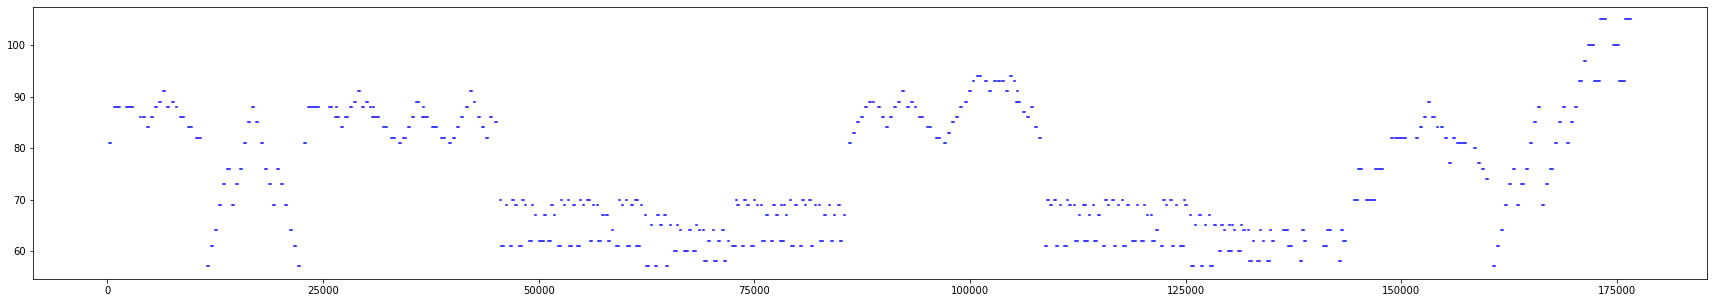

In [32]:
plot_data(data_r_regenerated)

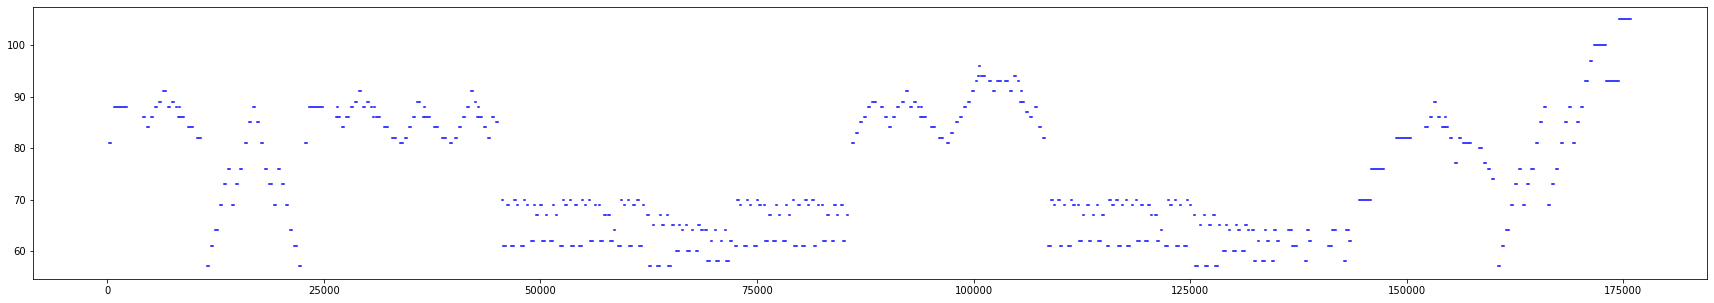

In [33]:
plot_data(data_r)

In [ ]:
_, data_r_regenerated_2 = transform_track(track_new_1)

plot_data(data_r_regenerated_2)

In [ ]:
data_r_regenerated_3 = concatenate_and_filter(sequences_r, 1200, stick = True)
track_new_3 = generate_inverse_midi(data_r_regenerated_3)
save_track([track_new_3], 'regen_albeniz_2.mid')
plot_data(data_r_regenerated_3)

70
-------------------------


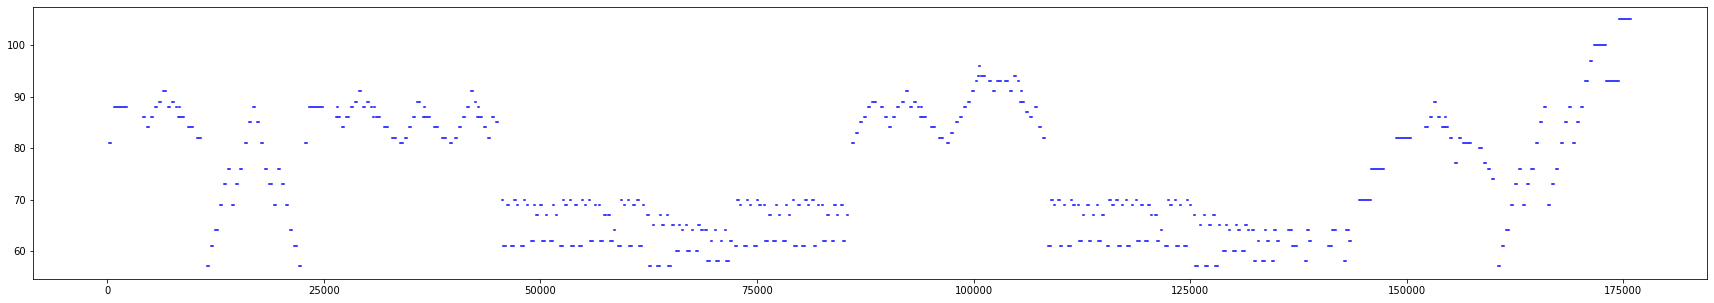

In [31]:
sequences_r = gen_seq(data_r, 1200)
data_r_regenerated_4 = concatenate_and_filter_2(sequences_r, 1200, stick = True)
track_new_4 = generate_inverse_midi(data_r_regenerated_4)
#save_track([track_new_4], 'regen_albeniz_3.mid')
plot_data(data_r_regenerated_4)